In [177]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

all_listings = json.loads(pathlib.Path('./all_listings.json').read_text())
df = pd.DataFrame(all_listings)
df.date_listed = pd.to_datetime(df.date_listed)

In [202]:
print(set(df.english_city.unique()))

{'Qiryat Gat', 'Alfe Menashe', 'Zur Hadassa', "Ari'el", "Ra'annana", 'Qiryat Bialik', 'Petah Tiqwa', "Giv'atayim", 'Dimona', "Be'er Ya'aqov", "Giv'at Ze'ev", 'Qadima- Zoran', 'Qiryat Ono', 'Ashdod', 'Tiberias', "Immanu'el", 'Qiryat Yam', 'Nesher', 'Eli', 'Ramla', 'Bene Beraq', 'Rosh HaAyin', "El'ad", 'Sederot', 'Or Yehuda', 'Migdal', 'Akko', 'Herzliyya', 'Shelomi', 'Hod HaSharon', 'Tel Mond', 'Qazrin', 'Rehovot', 'Zefat', 'Ramat Yishay', 'Elat', 'Migdal HaEmeq', 'Afula', 'Kefar Sava', "Yoqne'am Illit", "Ma'alot-Tarshiha", 'Rekhasim', 'Metar', "Qiryat Mal'akhi", 'Ganne Tiqwa', "Be'er Sheva", "Karmi'el", 'Qiryat Atta', 'Qarne Shomeron', 'Zur Yizhaq', 'Lehavim', 'Bat Yam', 'Qiryat Shemona', 'Tirat Karmel', 'Yeroham', 'Lod', 'Betar Illit', 'Haifa', 'Tel Aviv - Yafo', nan, "Yavne'el", 'Bet Shemesh', 'Ofaqim', 'Mizpe Ramon', 'Ramat Gan', "Modi'in-Makkabbim-Re'ut", 'Nahariyya', 'Qiryat Eqron', 'Rishon LeZiyyon', 'Avne Hefez', "Ma'ale Adummim", 'Nof HaGalil', "Giv'at Shemu'el", 'Geva Binyamin'

In [178]:
CENTRAL_BUREAU_OF_STATISTICS_EXCEL_URL = 'https://www.cbs.gov.il/he/publications/LochutTlushim/2020/%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%942020.xlsx'
city_names_and_populations = pd.read_excel(CENTRAL_BUREAU_OF_STATISTICS_EXCEL_URL,
                                           usecols='B,G,H', keep_default_na=False, skipfooter=7, header=7, sheet_name=0)
city_names_and_populations = city_names_and_populations.set_axis(['hebrew_city', 'city_population', 'english_city'], axis=1)
city_names_and_populations.city_population = city_names_and_populations.city_population.astype(int)

In [179]:
# fix specific cities to match
typos = {'תל אביב -יפו': 'תל אביב יפו', 'הרצלייה': 'הרצליה', 'קדימה-צורן': 'קדימה צורן', 'מודיעין-מכבים-רעות*': 'מודיעין מכבים רעות', 'קריית אונו': 'קרית אונו',
         'יהוד-מונוסון': 'יהוד מונוסון', 'קריית גת': 'קרית גת', 'קריית מלאכי': 'קרית מלאכי', 'קריית עקרון': 'קרית עקרון', 'גבע בנימין': 'אדם - גבע בנימין',
         'בית אריה-עופרים': 'בית אריה / עופרים', 'נהרייה': 'נהריה', 'קריית מוצקין': 'קרית מוצקין', 'קריית אתא': 'קרית אתא',
         'קריית ביאליק': 'קרית ביאליק', 'קריית ים': 'קרית ים', 'פרדס חנה-כרכור': 'פרדס חנה כרכור', 'נוף הגליל': 'נצרת עילית / נוף הגליל',
         'קריית שמונה': 'קרית שמונה', 'מעלות-תרשיחא': 'מעלות תרשיחא', 'קריית טבעון': 'קרית טבעון', 'בנימינה-גבעת עדה*': 'בנימינה גבעת עדה',
         'מיתר': 'מיתר / כרמית'}
city_names_and_populations = city_names_and_populations.replace(typos)

In [170]:
df = df.merge(city_names_and_populations, left_on='city', right_on='hebrew_city', how='left')
df = df.drop('city', axis=1)
# from what I saw about 1% of listings are in cities with a population of less than 2000,
# for simplicity we'll ignore them
df = df.dropna()
df.city_population = df.city_population.astype(int)

In [187]:
# CITIES_BLACKLIST = {'רמלה', 'לוד', 'אלעד', 'נתניה', 'כפר יונה', 'צור יצחק', 'גדרה', 'קרית עקרון', 'אשדוד', 'אשקלון', 'קרית גת', 'קרית מלאכי',
#                     'שדרות', 'בני עי"ש', 'ביתר עילית', 'אדם - גבע בנימין', 'עמנואל', 'גבעת זאב', 'עלי', 'קרני שומרון', 'אפרת', 'אבני חפץ', 'מודיעין עילית'}
CITIES_BLACKLIST = set()
MIN_AMOUNT_OF_LISTINGS_IN_CITY = 9

# drop erroneos extreme rows to clean data set
df = df[(df.area < df.area.mean() * 5) & (df.area > df.area.mean() / 10)]
df = df[df.date_listed > (pd.Timestamp.today() - pd.Timedelta(16, unit='W'))]
listing_count_by_city = df.hebrew_city.value_counts()
# print(listing_count_by_city)
cities_to_ignore = CITIES_BLACKLIST | \
    set(listing_count_by_city.loc[lambda listing_count: listing_count < MIN_AMOUNT_OF_LISTINGS_IN_CITY].index)
df = df[~df.hebrew_city.isin(cities_to_ignore)]
df = df.reset_index(drop=True)
display(df)
df.describe()

,date_listed,city,neighborhood,street,coordinates,floor,rooms,area,price,hebrew_city,city_population,english_city
0,2022-12-18 12:01:20,נתניה,נאות הרצל,גיורא יוספטל,"{'latitude': 32.326655, 'longitude': 34.867358}",1,4,80,1550000,נתניה,231983.0,Netanya
1,2022-12-01 21:58:15,נתניה,מרכז העיר דרום,הגליל,"{'latitude': 32.323311, 'longitude': 34.854168}",1,2,70,2000000,נתניה,231983.0,Netanya
2,2022-12-12 08:22:26,כפר סבא,ארלוזורוב,גאולה,"{'latitude': 32.173921, 'longitude': 34.899314}",2,4,110,2850000,כפר סבא,101746.0,Kefar Sava
3,2022-09-06 20:28:39,נתניה,נווה איתמר,משמר הירדן,"{'latitude': 32.327991, 'longitude': 34.874896}",4,4,92,2380000,נתניה,231983.0,Netanya
4,2022-10-03 13:15:45,נתניה,גלי הים,דוד רזניק,"{'latitude': 32.293989, 'longitude': 34.84437}",1,3,102,2690000,נתניה,231983.0,Netanya
...,...,...,...,...,...,...,...,...,...,...,...,...
16505,2022-11-20 18:00:45,טבריה,שיכון עובדים,סייפן,"{'latitude': 32.79990988, 'longitude': 35.5225...",5,6,180,1550000,טבריה,48395.0,Tiberias
16506,2022-11-27 10:02:50,חיפה,גאולה,בצלאל,"{'latitude': 32.8033542068966, 'longitude': 35...",0,7,125,1850000,חיפה,288543.0,Haifa
16507,2022-12-01 11:28:20,חיפה,קרית חיים מערבית,None,"{'latitude': 32.832021, 'longitude': 35.05874}",0,5,350,2500000,חיפה,288543.0,Haifa
16508,2022-10-25 13:11:42,קרית ביאליק,"מרכז העיר, סביניה, הוותיקה",None,"{'latitude': 32.834328, 'longitude': 35.087321}",5,5,186,2600000,קרית ביאליק,44476.0,Qiryat Bialik


,floor,rooms,area,price,city_population
count,16510.000000,16510.000000,16510.000000,1.651000e+04,16357.000000
mean,2.978740,3.860933,117.015203,2.065462e+06,203098.310081
std,3.179294,1.040075,69.355773,5.556494e+05,229054.261953
min,-5.000000,0.000000,17.000000,1.000000e+06,2026.000000
25%,1.000000,3.000000,80.000000,1.600000e+06,53104.000000
50%,2.000000,4.000000,102.000000,2.080000e+06,152660.000000
75%,4.000000,4.000000,127.000000,2.550000e+06,254523.000000
max,58.000000,11.000000,780.000000,3.000000e+06,978036.000000


Text(0.5, 1.0, 'Distribution of the Area of Listings')

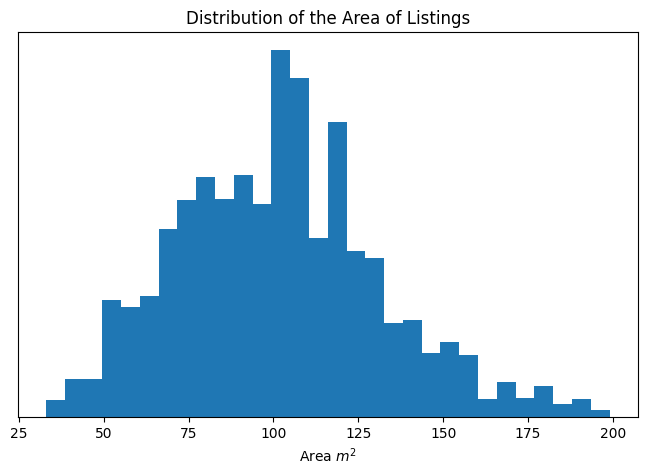

In [156]:
plot = df[df.area < 200].area.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Area $m^2$')
plot.set_title('Distribution of the Area of Listings')

Text(0.5, 1.0, 'Distribution of Prices')

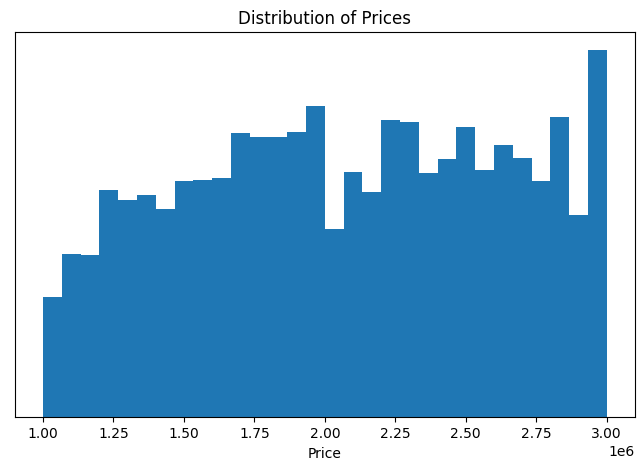

In [157]:
plot = df.price.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Price')
plot.set_title('Distribution of Prices')

Text(0.5, 1.0, 'Distribution of Dates Listed')

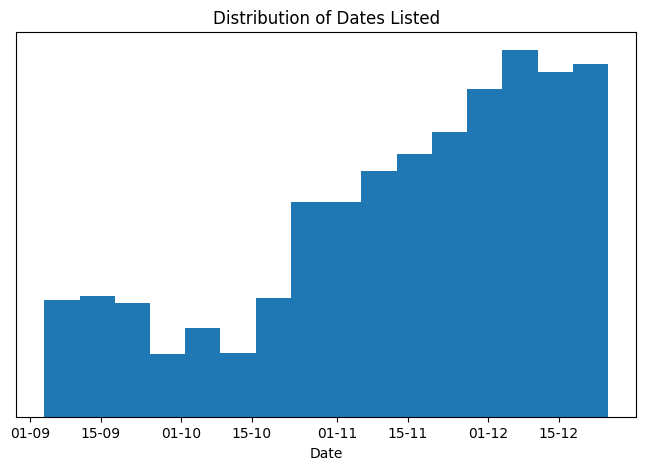

In [158]:
import matplotlib

plot = df.date_listed.hist(bins=16, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Date')
plot.get_xaxis().set_major_formatter(matplotlib.dates.DateFormatter('%d-%m'))
plot.set_title('Distribution of Dates Listed')

Text(0.5, 1.0, 'Day of the Week Listed')

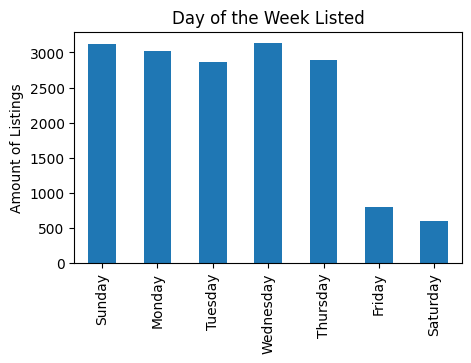

In [159]:
import calendar

WEEKDAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plot = pd.Series([calendar.day_name[date.weekday()] for date in df.date_listed]).value_counts().\
    sort_index(key=lambda day_names: [WEEKDAYS.index(day_name) for day_name in day_names]).plot.bar(figsize=(5,3))
plot.set_ylabel('Amount of Listings')
plot.set_title('Day of the Week Listed')

Text(0.5, 1.0, 'Distribution of Number of Rooms')

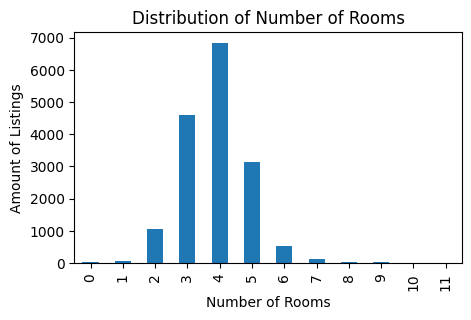

In [160]:
plot = df.rooms.value_counts().sort_index().plot.bar(figsize=(5,3))
plot.set_xlabel('Number of Rooms')
plot.set_ylabel('Amount of Listings')
plot.set_title('Distribution of Number of Rooms')

Text(0.5, 1.0, 'Time of Day Listings Were Posted')

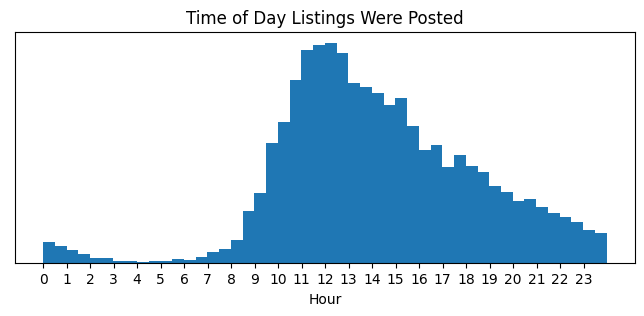

In [161]:
plot = pd.Series([date_listed.time().hour + date_listed.time().minute / 60 for date_listed in df.date_listed])\
    .hist(bins=48, figsize=(8, 3), grid=False)
plot.get_yaxis().set_visible(False)
plot.get_xaxis().set_ticks([i for i in range(0, 24, 1)])
plot.set_xlabel('Hour')
plot.set_title('Time of Day Listings Were Posted')

Text(0.5, 1.0, 'Distribution of Floor Number')

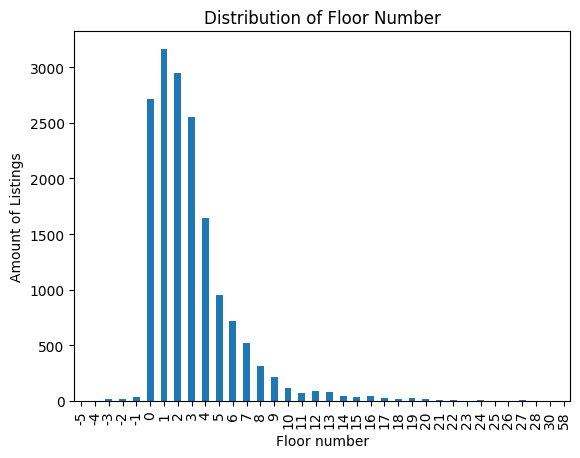

In [162]:
plot = df.floor.value_counts().sort_index().plot.bar()
plot.set_xlabel('Floor number')
plot.set_ylabel('Amount of Listings')
plot.set_title('Distribution of Floor Number')

Text(0.5, 1.0, 'Amount of Listings, and the Price per Square Meter, for each City')

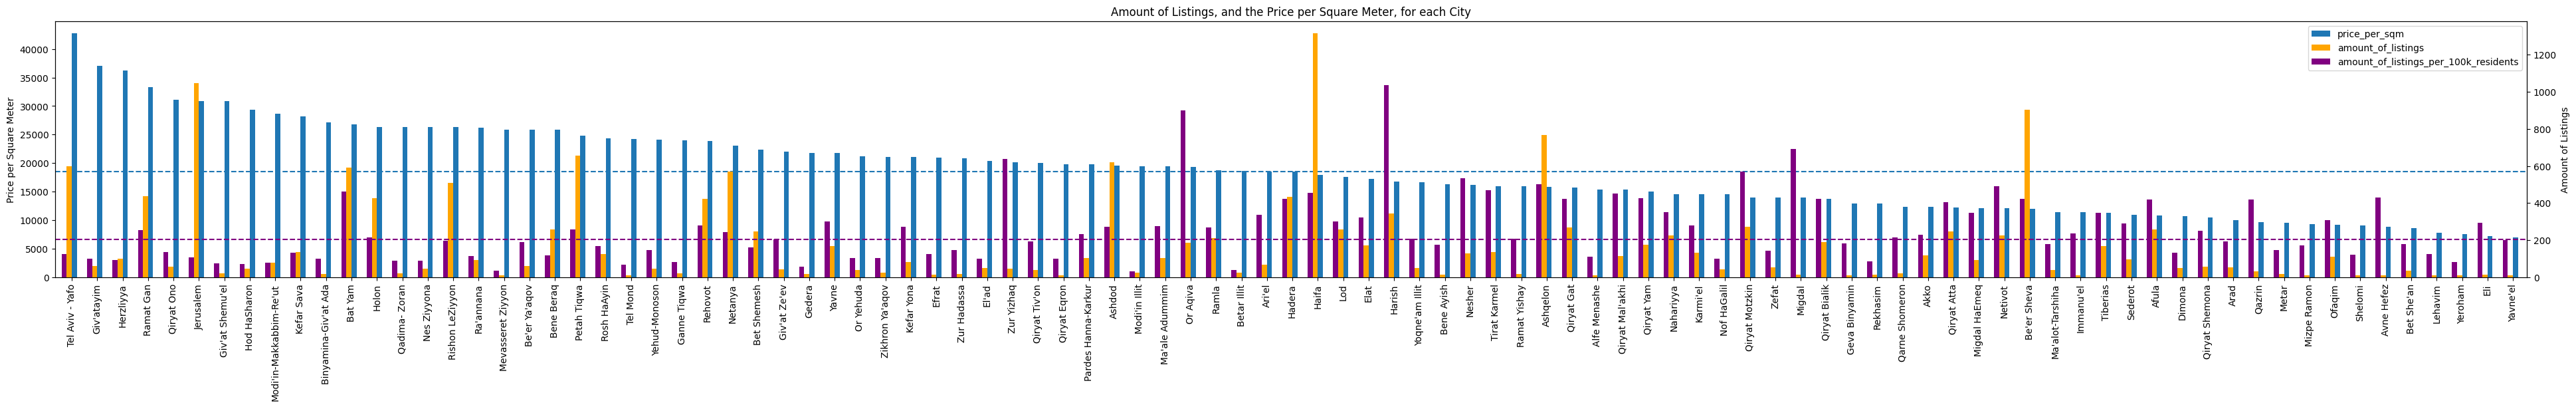

In [193]:
# create df
amount_of_listings = df.english_city.value_counts()
amount_of_listings.name = 'amount_of_listings'
df['price_per_sqm'] = df.price / df.area
prices_per_sqm = df.groupby('english_city').mean(numeric_only=True)['price_per_sqm'].sort_values(ascending=False).astype(int)
df = df.drop('price_per_sqm', axis=1)
cities_df = pd.merge(prices_per_sqm, amount_of_listings, left_index=True, right_index=True)
cities_df = cities_df.merge(city_names_and_populations, left_index=True, right_on='english_city')
cities_df = cities_df.set_index('english_city')
cities_df['amount_of_listings_per_100k_residents'] = ((cities_df.amount_of_listings / cities_df.city_population) * 100000).astype(int)
median_amount_of_listings_per_100k_residents = cities_df.amount_of_listings_per_100k_residents.median()
median_price_per_sqm = cities_df.price_per_sqm.median()

# plotting
fig, ax = plt.subplots()
ax2 = ax.twinx()
cities_df.price_per_sqm.plot.bar(ax=ax, width=0.2, position=0)
cities_df.amount_of_listings.plot.bar(ax=ax2, width=0.2, color='orange', position=1)
cities_df.amount_of_listings_per_100k_residents.plot.bar(ax=ax2, width=0.2, color='purple', position=2)
ax.set_ylabel('Price per Square Meter')
ax2.set_ylabel('Amount of Listings')
ax.set_xlim(right=(ax.get_xlim()[1] + 0.25))
ax2.set_xlim(right=(ax2.get_xlim()[1] + 0.25))
ax.set_xlabel(None)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.axhline(y=median_price_per_sqm, linestyle='--')
ax2.axhline(y=median_amount_of_listings_per_100k_residents, color='purple', linestyle='--')
ax.legend(lines + lines2, labels + labels2, loc='upper right')
fig.set_size_inches(int(cities_df.shape[0] / 2), 5)
ax.set_title('Amount of Listings, and the Price per Square Meter, for each City')

In [12]:
# Ideas for graphs:
# stats of the median apartment properties per city per price point for top 5-10 cities
# gather rent listings and match apartemnts with same city & area (in buckets of 10-20) to find price/rent ratios

,date_listed,city,neighborhood,street,coordinates,floor,rooms,area,price
0,2022-12-04 14:23:12,Kfar Saba,קרית ספיר,רוטשילד,"{'latitude': 32.176736, 'longitude': 34.908623}",2,4,125,2980000
1,2022-12-12 08:22:26,Kfar Saba,ארלוזורוב,גאולה,"{'latitude': 32.173921, 'longitude': 34.899314}",2,4,110,2850000
2,2022-12-19 22:21:56,Ra'anana,מרכז דרום,הרצוג,"{'latitude': 32.179599, 'longitude': 34.87328}",0,4,106,2700000
3,2022-12-09 12:12:02,Kfar Saba,ארלוזורוב,אברהם קרן,"{'latitude': 32.170754, 'longitude': 34.91112}",2,4,121,2990000
4,2022-12-04 14:31:01,Ra'anana,קרית ויצמן,None,"{'latitude': 32.185308, 'longitude': 34.866941}",1,4,132,2870000
...,...,...,...,...,...,...,...,...,...
5062,2022-10-11 11:01:59,Ariel,רובע ג',ששת הימים,"{'latitude': 32.1055486296296, 'longitude': 35...",1,2,55,1600000
5063,2022-11-21 10:41:52,Ariel,None,דרך אפרתה,"{'latitude': 32.103392, 'longitude': 35.19577}",2,7,140,1880000
5064,2022-12-04 15:18:54,Ariel,None,אבנר,"{'latitude': 32.10746, 'longitude': 35.185433}",3,5,130,1800000
5065,2022-12-15 11:32:37,Ariel,None,מוריה,"{'latitude': 32.101711, 'longitude': 35.205824}",3,5,113,2200000


array([ 28.,  57.,  69.,  75.,  82.,  90.,  96., 101., 110., 121., 452.])

array([1000000., 1800000., 1990000., 2180000., 2300000., 2450000.,
       2580000., 2690000., 2800000., 2900000., 3000000.])

Text(0.5, 1.0, 'Distribution of the Area of Listings')

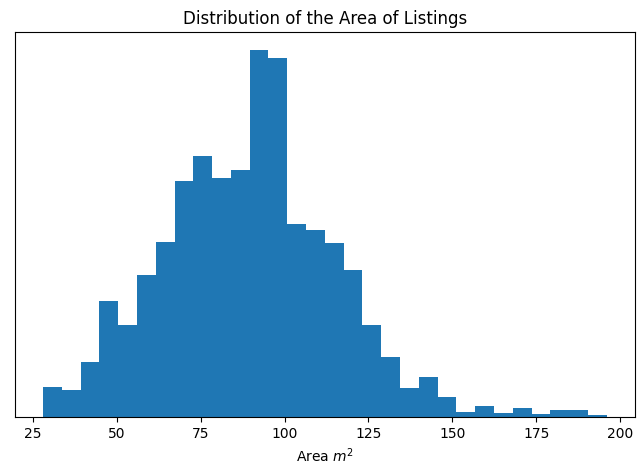

In [13]:
# display(df.neighborhood.value_counts())
display(df)
d1 = df.copy()
# d1.area = [round(area, -1) for area in df.area]
_, area_bins = pd.qcut(df.area, 10, retbins=True)
_, price_bins = pd.qcut(df.price, 10, retbins=True)
display(area_bins, price_bins)

plot = df[df.area < 200].area.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Area $m^2$')
plot.set_title('Distribution of the Area of Listings')